# Business Problem

Air pollution is a growing concern worldwide, impacting both the environment and human health. To support proactive decision-making, it is essential to develop models that can accurately classify air quality based on measurable environmental and demographic factors.

This project aims to create a machine learning model that classifies air quality levels (Good, Moderate, Poor, or Hazardous) with a target performance of over 75% accuracy (or equivalent metric such as F1-score). Such a model can assist policymakers, environmental agencies, and communities in monitoring pollution and mitigating its effects.

# Project Objectives

1. Preprocess and Clean the Dataset
Handle missing values, outliers, and ensure the dataset is well-formatted for modeling.

2. Explore and Analyze Feature Relationships
Understand the impact of environmental and demographic variables on air quality levels through visualizations and correlation analysis.

3. Train Classification Models and Evaluate Performance
Apply classification algorithms (Logistic Regression, Decision Trees, Random Tress, XGBoost) and optimize them to achieve at least 75% accuracy or equivalent performance.

4. Select the Best Model and Interpret Results
Pick the model that works best and use it to draw recommendations

# Dataset Overview

The dataset contains 5,000 records, each representing air quality observations in a specific region. The key features include:

- Temperature (°C)

- Humidity (%)

- PM2.5, PM10 (µg/m³)

- NO2, SO2 (ppb)

- CO (ppm)

- Proximity to Industrial Areas (km)

- Population Density (people/km²)

- Target: Air Quality Level (Good, Moderate, Poor, Hazardous)

# Tools Used

Python (Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn)

Jupyter Notebook

Classification Models (Logistic Regression, Decision Tress)


## Step 1: Load Data, Inspect and Preprocess

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, make_scorer, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Load the data
df = pd.read_csv('updated_pollution_dataset.csv')
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [3]:
# check for the info
print(df.info())
print(f'The dataset has {df.shape[1]} columns and {df.shape[0]} rows')
# for column in df.columns:
#     print(f'The column "{column}" is of type {df[column].dtype}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB
None
The dataset has 10 columns and 5000 rows


In [4]:
# check for duplicates
duplicates = df.duplicated()
print(f' Number of duplicates: {sum(duplicates)}')

 Number of duplicates: 0


There are no duplicates in the dataset

In [5]:
# check for missing values
df.isna().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

The dataset is clean as it has no missing values

In [6]:
# check for outliers in numerical columns

# Select only numerical columns
numeric_cols = df.select_dtypes(include='number')

# Calculate IQR for each numeric column
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Identify rows with outliers
outlier_mask = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
df_outliers = df[outlier_mask.any(axis=1)]

print(f"Number of rows with outliers: {df_outliers.shape[0]}")



Number of rows with outliers: 593


In [7]:
# replace outliers with median

df_imputed = numeric_cols.copy()

for col in numeric_cols.columns:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    median = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].apply(
        lambda x: median if x < lower or x > upper else x
    )

# Replace in original DataFrame
df[numeric_cols.columns] = df_imputed
df_imputed


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319.0
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611.0
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619.0
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551.0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303.0
...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,12.0,21.7,45.5,25.7,2.11,2.8,765.0
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709.0
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379.0
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241.0


In [8]:
# Rejoin the categorical columns to the imputed dataframe

# Get the categorical columns from the original DataFrame
categorical_cols = df.select_dtypes(exclude='number')

# Concatenate imputed numeric and original categorical columns
df_final = pd.concat([df_imputed, categorical_cols], axis=1)

df_final.head()


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319.0,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611.0,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619.0,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551.0,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303.0,Good


## Step 2: Perform Exploratory Data Analysis (EDA)

In [9]:
# check for the decriptive statistics 
df_final.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,29.713060,69.870940,14.730400,24.645420,26.009500,9.44880,1.483540,8.381560,496.798400
std,6.218252,15.576654,13.152195,16.169856,8.284051,5.85351,0.518861,3.531162,151.849148
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.20000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.10000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.00000,1.410000,7.900000,494.000000
75%,33.700000,80.200000,20.625000,32.400000,31.325000,12.90000,1.820000,11.000000,600.000000
max,47.300000,113.100000,58.300000,76.800000,49.500000,26.60000,3.040000,19.400000,927.000000


In [10]:
# check for target class imbalance
df_final['Air Quality'].value_counts()

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

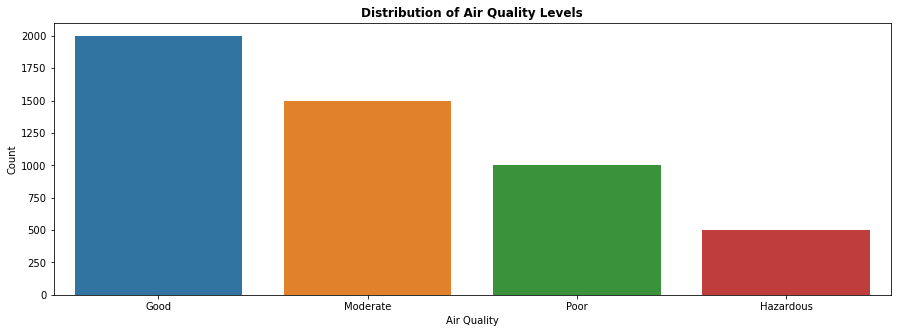

In [11]:
# plot a countplot of the target class
plt.figure(figsize=(15, 5))
sns.countplot(x='Air Quality', data=df_final, order=['Good', 'Moderate', 'Poor', 'Hazardous'])
plt.title('Distribution of Air Quality Levels', fontweight = 'bold')
plt.ylabel('Count')
plt.xlabel('Air Quality')
plt.show()

-> The dataset is imbalanced although not severe, we can impute using Smote

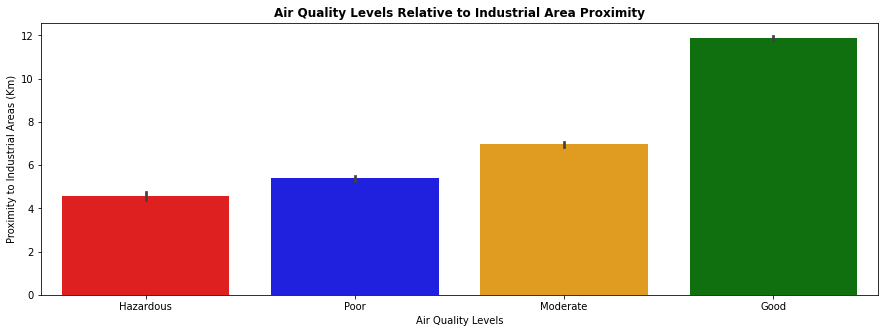

In [12]:
# plot a graph of air quality against Proximity_to_Industrial_Areas

plt.figure(figsize=(15, 5))
custom_palette = {
    'Good': 'green',
    'Moderate': 'orange',   
    'Poor': 'blue',       
    'Hazardous': 'red'
}

# groupby the columns and sort them out by their index
order = df_final.groupby('Air Quality')['Proximity_to_Industrial_Areas'].mean().sort_values().index

sns.barplot(x=df_final['Air Quality'], y=df_final['Proximity_to_Industrial_Areas'], order=order,  palette=custom_palette)

plt.title('Air Quality Levels Relative to Industrial Area Proximity',fontweight = 'bold')
plt.xlabel('Air Quality Levels')
plt.ylabel('Proximity to Industrial Areas (Km)')
plt.show();


-> This graph indicates that the closer an area is to an industrial area, the more polluted the air quality tends to be.

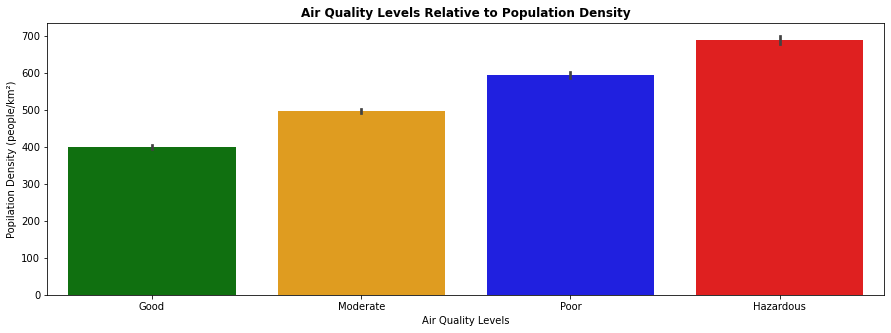

In [13]:
# Plot a graph of air quality levels against population density

plt.figure(figsize=(15, 5))
custom_palette = {
    'Good': 'green',
    'Moderate': 'orange',   
    'Poor': 'blue',       
    'Hazardous': 'red'
}

# groupby the columns and sort them out by their index
order = df_final.groupby('Air Quality')['Population_Density'].mean().sort_values().index

sns.barplot(x=df_final['Air Quality'], y=df_final['Population_Density'], order=order, palette=custom_palette)

plt.title('Air Quality Levels Relative to Population Density', fontweight = 'bold')
plt.xlabel('Air Quality Levels')
plt.ylabel('Popilation Density (people/km²)')
plt.show();


-> This graph indicates that areas with larger populations tend to have more polluted or hazardous air, while less         populated areas generally experience better air quality.

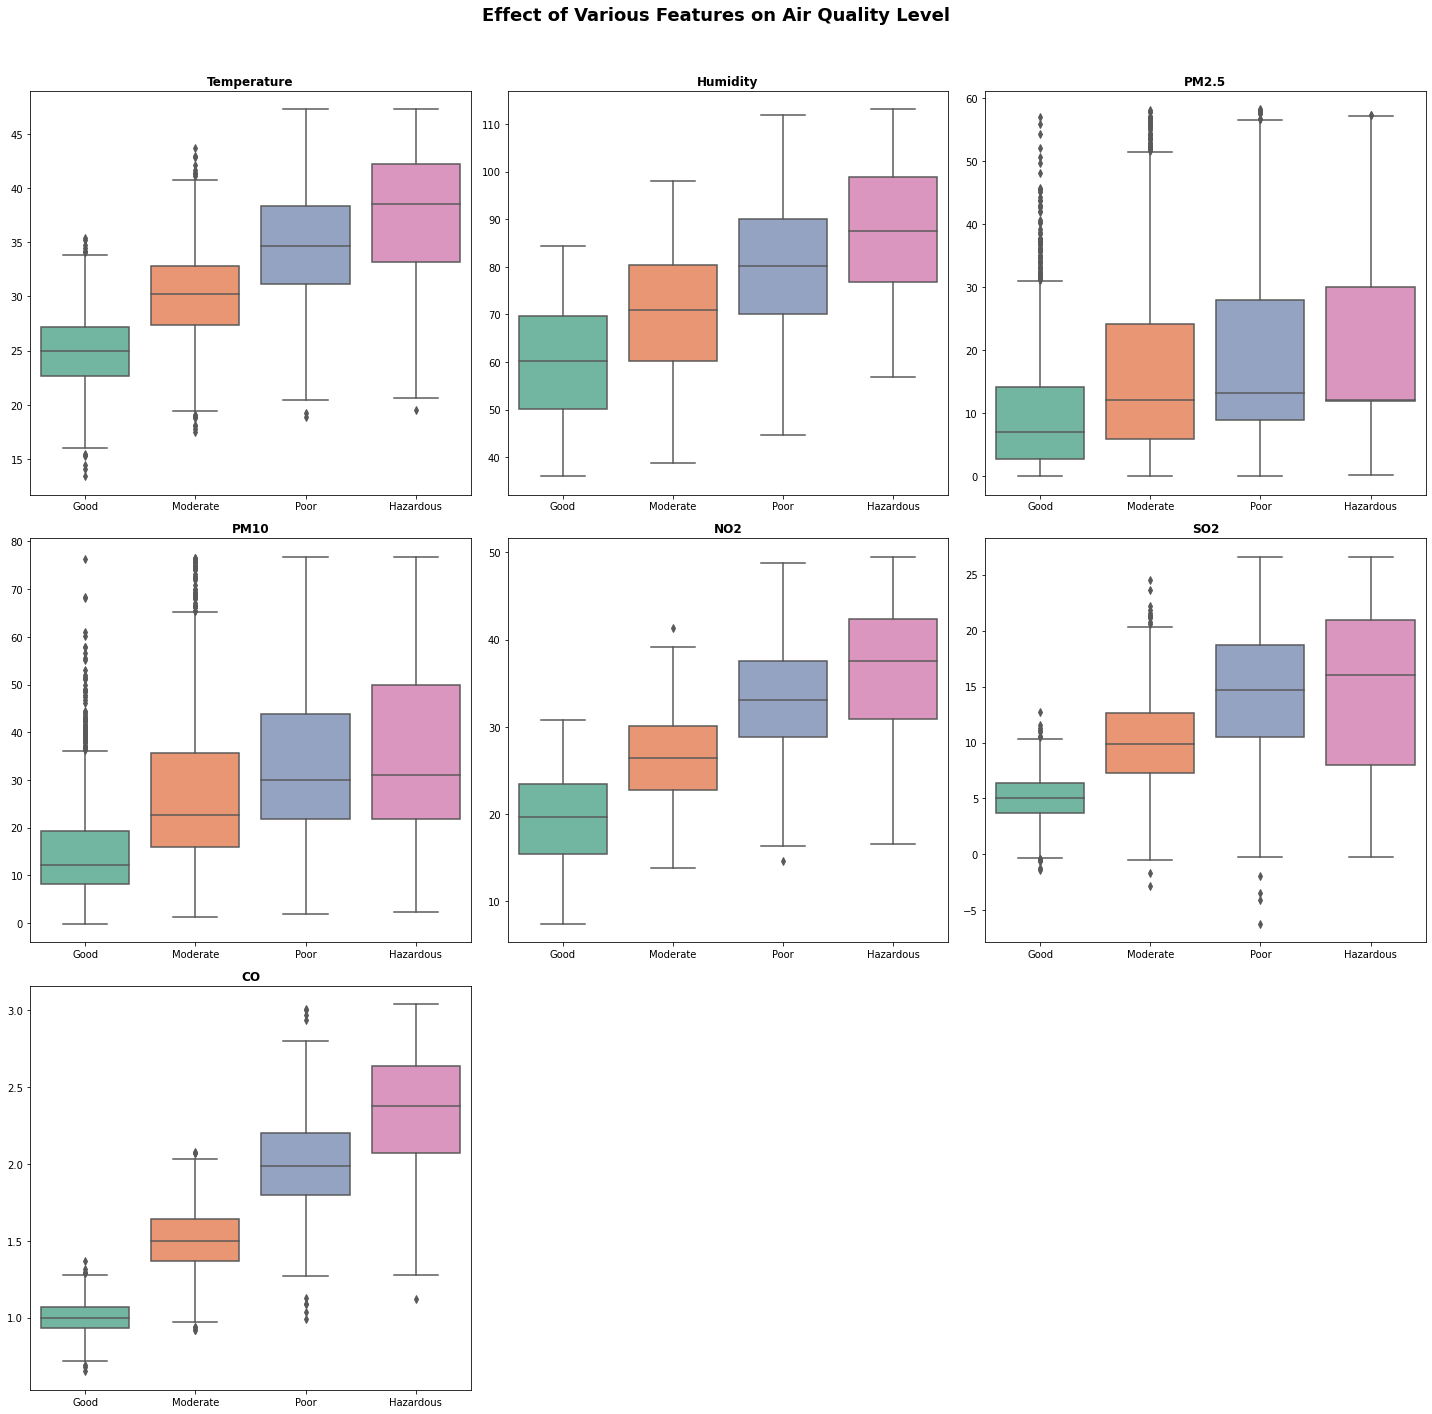

In [14]:
# Plot a boxplot of the air quality against he other remaining features

# Set plot style and size
plt.figure(figsize=(20, 20))
plt.suptitle('Effect of Various Features on Air Quality Level', fontsize=18, fontweight='bold')

features = [
    'Temperature', 
    'Humidity', 
    'PM2.5', 
    'PM10', 
    'NO2', 
    'SO2', 
    'CO'
]

order = ['Good', 'Moderate', 'Poor', 'Hazardous']

# Create subplots for each feature
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Air Quality', y=feature, data=df_final, palette='Set2', order=order)
    plt.title(feature, fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- From the boxplots, it's clear that PM2.5 and PM10 levels go up as the air quality gets worse, from Good to Hazardous. This means they play a big role in how bad the air is.

- CO also rises with poor air quality, so it's another important factor.

- NO2 and SO2 change a bit across the different air quality levels, but not as much. They still have some effect, just not as strong.

- Humidity and Temperature don’t seem to change much between the categories, so they probably don’t affect air quality that much.

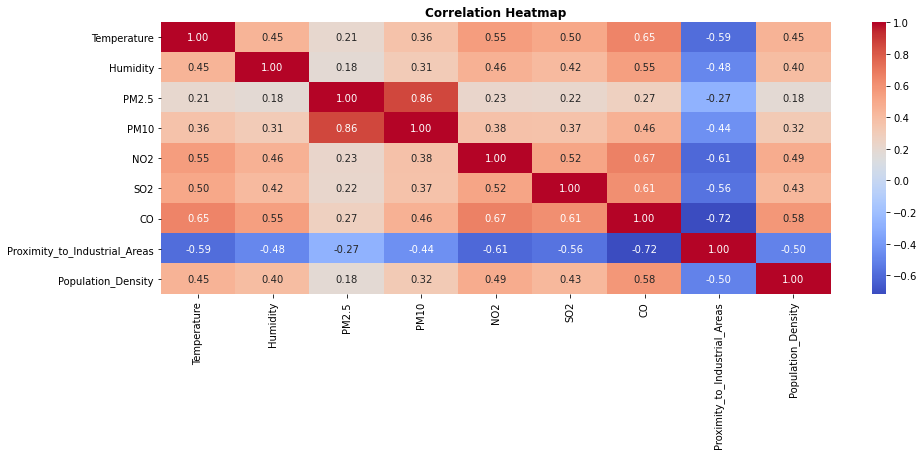

In [15]:
# Plot a correlation for the numeric columns only 

plt.figure(figsize=(15,5))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', fontweight = 'bold')
plt.show();


- PM2.5 and PM10 are strongly related and both increase when air quality gets worse.

- PM2.5, PM10, NO2, and CO have a strong positive correlation with the Air Quality Index (AQI), meaning they are major contributors to air pollution.

- SO2 and Temperature have a weaker impact on AQI compared to other pollutants.

- Proximity to industrial areas shows a negative correlation with AQI, meaning the farther a place is from industrial zones, the better its air quality. This is expected since factories often release pollutants, so areas closer to them tend to have worse air quality.

- Population density is most strongly linked to CO levels because many everyday human activities release carbon (II) oxide.

- Humidity is negatively related to pollution - higher humidity usually means better air quality because moisture helps settle dust and pollutants.

## Step 3: Modelling

## (i) Modelling Preprocessing

In [16]:
# Encode the target variable

le = LabelEncoder()
df_final['Air Quality Encoded'] = le.fit_transform(df_final['Air Quality'])

# Convert encoded values to float
df_final['Air Quality Encoded'] = df_final['Air Quality Encoded'].astype(float)

# Check mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'Good': 0, 'Hazardous': 1, 'Moderate': 2, 'Poor': 3}


In [17]:
X = df_final.drop(columns=['Air Quality', 'Air Quality Encoded'])
y = df_final['Air Quality Encoded']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
4227,38.8,92.5,8.3,29.0,32.8,8.3,2.19,3.9,698.0
4676,26.3,54.1,0.9,10.3,25.1,4.5,0.95,10.1,316.0
800,37.2,111.3,0.2,8.8,31.9,18.5,2.12,7.7,753.0
3671,17.5,57.2,8.7,13.6,25.6,3.1,1.03,11.6,505.0
4193,26.7,54.8,5.8,11.3,15.8,4.5,1.25,11.8,565.0
...,...,...,...,...,...,...,...,...,...
4426,30.0,59.7,12.0,68.8,22.1,7.4,1.39,5.1,412.0
466,27.7,54.0,17.6,23.2,24.6,11.1,1.27,7.8,638.0
3092,24.2,67.6,19.4,35.1,24.2,9.6,1.91,6.2,422.0
3772,21.4,76.4,15.3,22.1,12.4,3.4,0.96,16.3,420.0


In [18]:
# Scale the X values using MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create DataFrame for scaled training data
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_df
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled_df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
1501,0.528024,0.485084,0.205832,0.284416,0.425178,0.710366,0.790795,0.005917,0.767253
2586,0.312684,0.425422,0.013722,0.114286,0.320665,0.262195,0.213389,0.473373,0.063599
2653,0.353982,0.552529,0.070326,0.089610,0.330166,0.466463,0.313808,0.449704,0.480379
1055,0.510324,0.856031,0.135506,0.341558,0.812352,0.984756,0.694561,0.136095,0.780785
705,0.386431,0.234760,0.210978,0.201299,0.306413,0.350610,0.142259,0.603550,0.251691
...,...,...,...,...,...,...,...,...,...
4711,0.601770,0.412451,0.090909,0.088312,0.332542,0.490854,0.246862,0.295858,0.254398
2313,0.271386,0.324254,0.322470,0.336364,0.180523,0.256098,0.154812,0.721893,0.148850
3214,0.516224,0.732815,0.416810,0.388312,0.653207,0.737805,0.414226,0.390533,0.663058
2732,0.424779,0.617380,0.406518,0.487013,0.444181,0.439024,0.238494,0.289941,0.313938


In [19]:
# Use SMOTE to oversample and solve the imbalance

smt = SMOTE()
X_train_resampled, y_train_resampled = smt.fit_resample(X_train_df,y_train)

## (ii) Build a logistic regression model using statsmodels

In [20]:
# Add constant
X_train_const = sm.add_constant(X_train_df)

# Fit Multinomial Logistic Regression
model = sm.MNLogit(y_train, X_train_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.212466
         Iterations 14
                           MNLogit Regression Results                          
Dep. Variable:     Air Quality Encoded   No. Observations:                 4000
Model:                         MNLogit   Df Residuals:                     3970
Method:                            MLE   Df Model:                           27
Date:                 Sat, 31 May 2025   Pseudo R-squ.:                  0.8339
Time:                         22:49:05   Log-Likelihood:                -849.86
converged:                        True   LL-Null:                       -5115.3
Covariance Type:             nonrobust   LLR p-value:                     0.000
        Air Quality Encoded=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -67.2092      4.123    -16.30

### Model Interpretation

- Pseudo R-squares = 0.8339; The model explains 83% of the variability in air quality categories.

- LLR p-value = 0.000; The model is statistically significant

### Below is a breakdown of the predictors and how they influence the air quality

→ CO (Carbon (II) Oxide) – Coefficient: 78.37
 The strongest positive predictor. A one-unit increase in CO greatly increases the likelihood of poor air quality.

→ NO2 (Nitrogen Dioxide) – Coefficient: 27.03
 A strong positive contributor. Higher NO2 levels significantly raise the chance of poor air quality

→ SO2 (Sulfur Dioxide) – Coefficient: 26.64
 Significantly increases the likelihood of poor air quality.

→ Proximity to Industrial Areas – Coefficient: -29.84
 Strong negative effect. As distance from industrial areas decreases, the risk of poor air quality increases sharply.

→ Temperature – Coefficient: 25.48
 Higher temperatures are associated with worse air quality, possibly due to enhanced chemical reactions or trapped pollutants.

→ Population Density – Coefficient: 15.22
 Densely populated areas are more likely to have poor air quality due to more pollution from human activities.

 → PM10 (Coarse Particulate Matter) – Coefficient: 9.02
 Has a mild positive effect. Higher PM10 slightly increases the chance of poor air quality.

→ PM2.5 (Fine Particulate Matter) – Coefficient: -3.27
 Not a significant predictor. PM2.5 shows little to no clear impact on air quality in this model.
 
### Conclusion

- The best predictors of poor air quality are CO, NO2, SO2, population density, and proximity to industries.

- Humidity and PM10 have moderate influence.

- PM2.5 , although commonly used in pollution metrics, was not a strong predictor in this model on its own.

## (iii) Build a predictive model

In [21]:
# Cross validate using Logistic Regression 

logreg = LogisticRegression()
X_train_resampled = X_train_resampled[['CO', 'NO2', 'SO2', 'Population_Density','Proximity_to_Industrial_Areas']]
cv_logreg = cross_val_score(logreg, X_train_resampled,y_train_resampled, scoring= 'f1_macro')
cv_logreg = cv_logreg.mean()
print(f'Average F1 Macro Score for Logistic regression: {cv_logreg}')

Average F1 Macro Score for Logistic regression: 0.8455061436168047


In [22]:
# Cross validate using decision Trees

dt = DecisionTreeClassifier()
X_train_resampled = X_train_resampled[['CO', 'NO2', 'SO2', 'Population_Density','Proximity_to_Industrial_Areas']]
cv_dt = cross_val_score(dt, X_train_resampled,y_train_resampled, scoring='f1_macro')
cv_dt = cv_dt.mean()
print(f'Average F1 Macro Score for Decision Trees: {cv_dt}')

Average F1 Macro Score for Decision Trees: 0.8936920976736324


In [23]:
# Cross validate using Random Forest
rf = RandomForestClassifier()
X_train_resampled = X_train_resampled[['CO', 'NO2', 'SO2', 'Population_Density','Proximity_to_Industrial_Areas']]
cv_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, scoring='f1_macro')
cv_rf = cv_rf.mean()
print(f'Average F1 Macro Score for Random Forest: {cv_rf}')

Average F1 Macro Score for Random Forest: 0.9379111627473931


In [24]:
# cross validate using XGboost
xgb = XGBClassifier()
X_train_resampled = X_train_resampled[['CO', 'NO2', 'SO2', 'Population_Density','Proximity_to_Industrial_Areas']]
cv_xgb = cross_val_score(xgb, X_train_resampled,y_train_resampled, scoring='f1_macro')
cv_xgb = cv_xgb.mean()
print(f'Average F1 Macro Score for XGBoost: {cv_xgb}')

Average F1 Macro Score for XGBoost: 0.9340237237424244


- Based on the cross-validation results, the **Random Forest Classifier** achieved the highest F1_macro score, making it the most suitable model for fitting the training data and predicting the test set.

In [25]:
# fit the Random Forest classifier and use it to predict the test data
X_test_scaled_df = X_test_scaled_df[['CO', 'NO2', 'SO2', 'Population_Density','Proximity_to_Industrial_Areas']]
rf.fit(X_train_resampled, y_train_resampled) 

y_rf_train_pred = rf.predict(X_train_resampled) 
y_rf_test_pred = rf.predict(X_test_scaled_df)

In [26]:
# Test for overfitting or underfitting

train_f1_score = f1_score(y_train_resampled, y_rf_train_pred, average='macro')
test_f1_score = f1_score(y_test, y_rf_test_pred, average='macro')

print(f' The F1 score for train data is : {train_f1_score}')
print(f' The F1 score for test data is : {test_f1_score}')


 The F1 score for train data is : 1.0
 The F1 score for test data is : 0.8797640834274607


The model overfits as there is a significant difference between the Training f1_score and the Test f1_score.

It does performing perfectly on the training data but worse on unseen test data, which suggests it's memorizing rather than generalizing.